# Fine Tuning

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import shutil
import os 
import glob
import csv
import json
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix as confusion_matrix_sklearn

from ketos.data_handling import selection_table as sl
import ketos.data_handling.database_interface as dbi
from ketos.data_handling.parsing import load_audio_representation
from ketos.data_handling.data_feeding import BatchGenerator
from ketos.neural_networks.resnet import ResNetInterface
from ketos.audio.audio_loader import AudioFrameLoader, AudioLoader, SelectionTableIterator
from ketos.audio.spectrogram import MagSpectrogram
from ketos.neural_networks.dev_utils.detection import batch_load_audio_file_data, filter_by_threshold, filter_by_label, merge_overlapping_detections
from ketos.data_handling.data_feeding import JointBatchGen

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

print('done importing packages')

done importing packages


C:\Users\kzammit\Miniconda3\envs\ketos_env\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [2]:
def drop_rows(file_durations, table):

    drop = []

    print('cleaning training table of original length ' + str(len(table)))

    for idex, row in table.iterrows():
    
        # filename is row[0], end time is idex.end
        index = file_durations.loc[file_durations['filename'] == row.name[0]].index
        duration = file_durations['duration'][index].values[0]
    
        if duration < row.end:
            # drop the row corresponding to that sel_id and filename from the dataframe
            drop.append(idex)
    
        if row.start < 0:
            drop.append(idex)
    
    print('Number of rows to drop (note, one entry may be in list twice): ' + str(len(drop)))

    return drop

In [19]:
# Create a database
neg_folder = r'E:\final-baseline-detector\annots\neg'
pos_folder = r'E:\final-baseline-detector\annots\pos'
db_name = r'E:\final-baseline-detector\fine-tuning-pp\pp-split.h5'
data_folder = r'D:\ringed-seal-data'

## Create Database ##
# negatives tables and standarize for ketos
pp_neg = pd.read_excel(neg_folder + '\\' + 'PP-negs-joined.xlsx')
pp_neg = pp_neg.ffill()
pp_tr_neg = pp_neg.head(int(len(pp_neg)*(85/100)))
pp_te_neg = pp_neg[~pp_neg.index.isin(pp_tr_neg.index)]

pp_tr_neg = sl.standardize(table=pp_tr_neg)
pp_te_neg = sl.standardize(table=pp_te_neg)

print('Negatives standardized? ' + str(sl.is_standardized(pp_tr_neg)) + str(sl.is_standardized(pp_te_neg)))

pp_pos = pd.read_csv(pos_folder + '\\' + 'PP_all_formatted_1sec.csv')
pp_pos = pp_pos.ffill()
pp_tr_pos = pp_pos.head(int(len(pp_pos)*(85/100)))
pp_te_pos = pp_pos[~pp_pos.index.isin(pp_tr_pos.index)]

pp_tr_pos = sl.standardize(table=pp_tr_pos, start_labels_at_1=True)
pp_te_pos = sl.standardize(table=pp_te_pos, start_labels_at_1=True)

pp_tr = pd.concat([pp_tr_pos, pp_tr_neg])
pp_te = pd.concat([pp_te_pos, pp_te_neg])

spec_cfg = load_audio_representation(spectro_file, name="spectrogram")

dbi.create_database(output_file=db_name,  # empty brackets
                    dataset_name=r'train', selections=pp_tr, data_dir=data_folder,
                    audio_repres=spec_cfg)

dbi.create_database(output_file=db_name,  # empty brackets
                    dataset_name=r'test', selections=pp_te, data_dir=data_folder,
                    audio_repres=spec_cfg)

Negatives standardized? TrueTrue


100%|████████████████████████████████████████████████████████████████████████████████| 142/142 [00:02<00:00, 51.67it/s]


142 items saved to E:\final-baseline-detector\fine-tuning-pp\pp-split.h5


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 50.35it/s]

26 items saved to E:\final-baseline-detector\fine-tuning-pp\pp-split.h5


In [23]:
main_folder = r'E:\final-baseline-detector\fine-tuning-pp'
pretrained_model = r'E:\final-baseline-detector\final-baseline-model.kt'
new_model = main_folder + '\\' + 'pearce-point-fine-tuned-model.kt'
spectro_file = r'E:\final-baseline-detector\spec_config_100-1200Hz-0.032-hamm.json'

# Set the random seed for numpy and tensorflow
np.random.seed(1000)
tf.random.set_seed(2000)

# Set the batch size and number of epochs for training
batch_size = 16
n_epochs = 100

# Set the log folder and checkpoint folder
log_folder = main_folder + '\\' + 'logs'
checkpoint_folder = main_folder + '\\' + 'checkpoints'

# Open the database file in read mode
db = dbi.open_file(db_name, 'r')

# Open the training and validation tables respectively
train_data = dbi.open_table(db, "/train/data")
val_data = dbi.open_table(db, "/test/data")

# Create batches of training data of size batch size, using the specified data table
# This returns indices of the data in each batch along with their labels
train_generator = BatchGenerator(batch_size=batch_size, data_table=train_data,
                                    output_transform_func=ResNetInterface.transform_batch,
                                    shuffle=True, refresh_on_epoch_end=True)

# Create batches of validation data of size batch size, using the specified data table 
# This returns indices of the data in each batch along with their labels 
val_generator = BatchGenerator(batch_size=batch_size, data_table=val_data,
                                   output_transform_func=ResNetInterface.transform_batch,
                                   shuffle=False, refresh_on_epoch_end=False)

# Load the pretrained model, replacing the top (aka. classification layers). This method inherently freezes the base.
resnet = ResNetInterface.load(pretrained_model, replace_top=True)

# Set the training and validation generators to the batch generators created above
resnet.train_generator = train_generator
resnet.val_generator = val_generator

# Set the model log and checkpoint directory
resnet.log_dir = log_folder
resnet.checkpoint_dir = checkpoint_folder

# digging into their scripts for fine tuning
# resnet.py, "clone with new top"

# Train the model, looping through all of the training and validation data
# See code map for more information
resnet.train_loop(n_epochs=n_epochs, verbose=False, log_csv=True, csv_name='log.csv', validate=True)
#resnet.train_loop(n_epochs=n_epochs, verbose=False, log_csv=True, csv_name='log.csv', validate=False)

# Close the database
db.close()

# Save the model file, and keep track of the spectrogram parameters used to generate that model
resnet.save(new_model, audio_repr_file=spectro_file)

print('Done')

Done


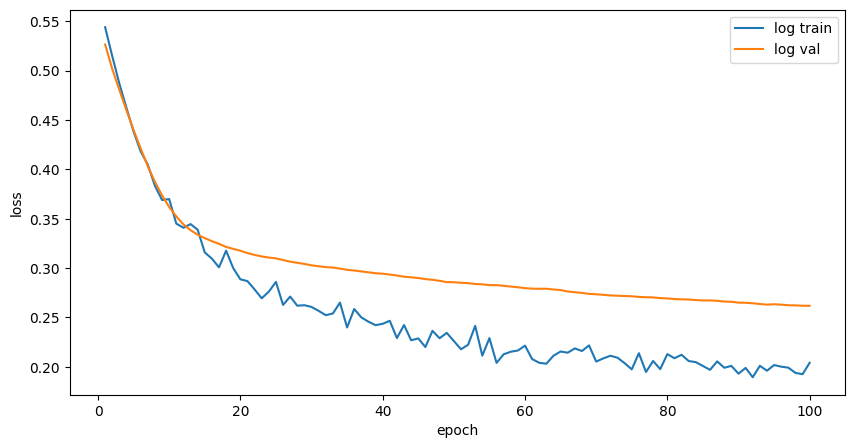

In [24]:
# Get path to folder containing logs 
log_folder = r'E:\final-baseline-detector\fine-tuning-pp\logs'

files = glob.glob(log_folder  + "/*.csv")

fig, axes = plt.subplots(1, 1, figsize=(10, 5), sharey=True)
#axes.set_ylim(0.1, 0.20)

for file in files:

    # Read the log file 
    log_file = pd.read_csv(file)

    labell = file.split('\\')[-1].split(".")[0]
    
    # Get the training and validation losses 
    tr_results = log_file[log_file['dataset']=='train']
    va_results = log_file[log_file['dataset']=='val']
    
    # Plot the loss curves 
    sns.lineplot(data=tr_results, x='epoch', y='loss', label= str(labell) + ' train', legend='auto')
    sns.lineplot(data=va_results, x='epoch', y='loss', label=str(labell) + ' val', legend='auto') 

## Run on audio files 

In [25]:
pearce_point_folder = r'E:\final-baseline-detector\fine-tuning-pp'
temp_folder_pp = pearce_point_folder + '\\' + 'ringedS_tmp_folder_ft'
detections_csv = pearce_point_folder + '\\' + 'detections_raw_fine_tuned.csv'
model_name = r'E:\final-baseline-detector\fine-tuning-pp\pearce-point-fine-tuned-model.kt'
audio_folder = r'E:\final-baseline-detector\pearce-point\audio'

# Look at detections at this threshold
threshold = 0.4

# Step 0.5s each time (overlap of 50% for 1 sec duration)
step_size = 0.5

# Number of samples in batch
batch_size = 16

model = ResNetInterface.load(model_file=model_name, new_model_folder=temp_folder_pp)

audio_repr = load_audio_representation(path=spectro_file)

spec_config = audio_repr['spectrogram']

audio_loader = AudioFrameLoader(path=audio_folder, duration=spec_config['duration'],
                                    step=step_size, stop=False, representation=spec_config['type'],
                                    representation_params=spec_config, pad=False)
detections = pd.DataFrame()

batch_generator = batch_load_audio_file_data(loader=audio_loader, batch_size=batch_size)

for batch_data in batch_generator:
    # Run the model on the spectrogram data from the current batch
    batch_predictions = model.run_on_batch(batch_data['data'], return_raw_output=True)

    # Lets store our data in a dictionary
    raw_output = {'filename': batch_data['filename'], 'start': batch_data['start'], 'end': batch_data['end'],
                  'score': batch_predictions}

    batch_detections = filter_by_threshold(raw_output, threshold=threshold)

    detections = pd.concat([detections, batch_detections], ignore_index=True)

detections.to_csv(detections_csv, index=False)

100%|████████████████████████████████████████████████████████████████████████████████| 598/598 [00:49<00:00, 12.12it/s]


In [26]:
# Filter the detections for only the positive results 
detections_filtered = filter_by_label(detections, labels=1).reset_index(drop=True)
print(detections_filtered)
detections_grp = merge_overlapping_detections(detections_filtered)
print(detections_grp)
detections_grp.to_csv(r'E:\final-baseline-detector\fine-tuning-pp\pos_detections_ft.csv', index=False)

                         filename  start    end  label     score
0     1208234033.020419202219.wav   57.5   58.5      1  0.793226
1     1208234033.020419202219.wav   58.0   59.0      1  0.941007
2     1208234033.020419202219.wav   58.5   59.5      1  0.485138
3     1208234033.020419202219.wav   69.0   70.0      1  0.427352
4     1208234033.020419202219.wav   69.5   70.5      1  0.960076
...                           ...    ...    ...    ...       ...
1322  1208234033.021207082219.wav  191.5  192.5      1  0.999871
1323  1208234033.021207082219.wav  192.0  193.0      1  0.975917
1324  1208234033.021207082219.wav  259.0  260.0      1  0.455004
1325  1208234033.021207082219.wav  259.5  260.5      1  0.485697
1326  1208234033.021207082219.wav  291.5  292.5      1  0.413139

[1327 rows x 5 columns]
                        filename  start    end  label     score
0    1208234033.020419202219.wav   57.5   59.5      1  0.676127
1    1208234033.020419202219.wav   69.0   71.0      1  0.561394
2  

In [27]:
results_table = detections_grp

cols = ['filename']
results_table.loc[:,cols] = results_table.loc[:,cols].ffill()
results_table['Selection'] = results_table.index +1
results_table['View'] = 'Spectrogram 1'
results_table['Channel'] = 1
results_table['Begin Path'] = audio_folder + '\\' + results_table.filename
results_table['File Offset (s)'] = results_table.start
results_table = results_table.rename(columns={"start": "Begin Time (s)", "end": "End Time (s)", "filename": "Begin File"})
results_table['Begin File'] = results_table['Begin File']
results_table['Low Freq (Hz)'] = 100
results_table['High Freq (Hz)'] = 1200

results_table.to_csv(r'E:\final-baseline-detector\pearce-point\fine-tuning-pp\raven-formatted-detections-ft.txt',
                     index=False, sep='\t')

## Run on Pearce Point database

In [9]:
def compute_detections(labels, scores, threshold=0.5):

    # Compute the positive scores above threshold, 1 if it is above threshold, 0 if it is not 
    predictions = np.where(scores >= threshold, 1,0)

    # TP: Does the annotated label match the prediction above threshold? Bc "scores" is defined as the positive threshold, this represents TP
    TP = tf.math.count_nonzero(predictions * labels).numpy()

    # TN: Negative score is "predictions - 1" bc predictions was for the positive result, labels-1 so that the negatives are multiplied by 1
    TN = tf.math.count_nonzero((predictions - 1) * (labels - 1)).numpy()

    # And so on 
    FP = tf.math.count_nonzero(predictions * (labels - 1)).numpy()
    FN = tf.math.count_nonzero((predictions - 1) * labels).numpy()

    return predictions, TP, TN, FP, FN

### Test Table from Pearce Point Split

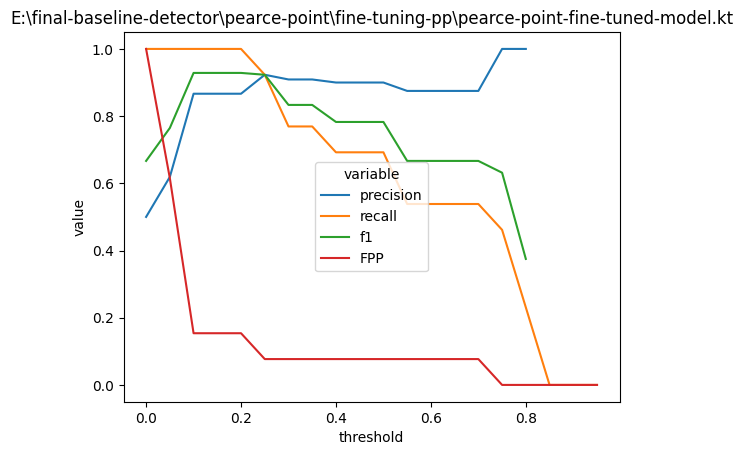

In [29]:
thresholds = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
#thresholds = [0.4]
step_size = 1.0
batch_size = 16
buffer = 0.5

# Get pathway to metrics folder
output_dir = r'E:\final-baseline-detector\pearce-point\fine-tuning-pp\metrics'
main_folder = r'E:\final-baseline-detector'
db_name = r'E:\final-baseline-detector\pearce-point\pp-split.h5'
model_name = r'E:\final-baseline-detector\pearce-point\fine-tuning-pp\pearce-point-fine-tuned-model.kt'
temp_folder = r'E:\final-baseline-detector\pearce-point\fine-tuning-pp\temp'

# Open the database in read only file
db = dbi.open_file(db_name, 'r')

# Open the table in the database at the root level
table = dbi.open_table(db, '/test')

classification_csv = "classifications.csv"
metric_csv = "metrics.csv"
stats_csv = "stats.csv"

# Load the trained model
model = ResNetInterface.load(model_name, load_audio_repr=False, new_model_folder=temp_folder)

# Initialize Joint Batch Generator
gens = []

# Calculate the batch_size fixing the original batch size so there are no remainders
batch_size = int(batch_size / sum(1 for _ in db.walk_nodes(table, "Table")))

# for the testing dataset table in the database (or whatever table is passed in)
for group in db.walk_nodes(table, "Table"):
    # Create a batch generator for this table
    generator = BatchGenerator(batch_size=batch_size, data_table=group,
                               output_transform_func=ResNetInterface.transform_batch, shuffle=False,
                               refresh_on_epoch_end=False, x_field='data', return_batch_ids=True)

    # Append the generator to the gens array
    gens.append(generator)

# Create a joint batch generator if multiple tables are passed through
gen = JointBatchGen(gens, n_batches='min', shuffle_batch=False, reset_generators=False, return_batch_ids=True)

# Initialize the scores and labels
scores = []
labels = []

# For each batch in the joint batch generator
for batch_id in range(gen.n_batches):
    # Get the ids, spectrograms, and labels for the data in the batch
    hdf5_ids, batch_X, batch_Y = next(gen)

    # Get the labels for the batch data, using the "argmax" func which returns the col header, so 0 is a noise segment, 1 is a rs segment
    batch_labels = np.argmax(batch_Y, axis=1)

    # Returns the scores for the batch for the "positive" class - this is used in the compute detections function later on
    batch_scores = model.model.predict_on_batch(batch_X)[:, 1]

    # Add these scores for this batch to the overall list
    scores.extend(batch_scores)
    labels.extend(batch_labels)

# Create a numpy array for the labels and scores for all batches
labels = np.array(labels)
scores = np.array(scores)

df_groups = pd.DataFrame()
df_stats = pd.DataFrame(columns = ['threshold', 'precision', 'recall', 'f1', 'FPP'])

for threshold in thresholds:

    df_group = pd.DataFrame()

    # Compute the predictions, TP, TN, FP, and FN
    # Predicted is an array are greater than a certain threshold, 1 for the score was, 0 for it was not
    predicted, TP, TN, FP, FN = compute_detections(labels, scores, threshold)

    # Create the "classifications" csv file
    for group in db.walk_nodes(table, "Table"):
        df = pd.DataFrame({'id': group[:]['id'], 'filename': group[:]['filename']})
        df_group = pd.concat([df_group, df], ignore_index=True)
    df_group['threshold'] = threshold
    df_group['label'] = labels[:]
    df_group['predicted'] = predicted[:]
    df_group['score'] = scores[:]

    # Calculate performance metrics
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)
    FPP = FP / (TN + FP)

    stats = [threshold, precision, recall, f1, FPP]

    df_groups = pd.concat([df_groups, df_group])
    df_stats.loc[len(df_stats)] = stats

df_groups.to_csv(os.path.join(os.getcwd(), output_dir, classification_csv), mode='w', index=False)
df_stats.to_csv(os.path.join(os.getcwd(), output_dir, stats_csv), mode='w', index=False)

sns.lineplot(x='threshold', y='value', hue='variable', data=pd.melt(df_stats, ['threshold']))
plt.title(model_name)

db.close()

In [13]:
def confusion_matrix_plot(cf, output_folder,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=True):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html

    title:         Title for the heatmap. Default is None.

    '''

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names) == cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten() / np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels, group_counts, group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0], cf.shape[1])

    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        # Accuracy is sum of diagonal divided by total observations
        accuracy = np.trace(cf) / float(np.sum(cf))

        # if it is a binary confusion matrix, show some more stats
        if len(cf) == 2:
            # Metrics for Binary Confusion Matrices
            precision = cf[1, 1] / sum(cf[:, 1])
            recall = cf[1, 1] / sum(cf[1, :])
            f1_score = 2 * precision * recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy, precision, recall, f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""

    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize == None:
        # Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks == False:
        # Do not show categories if xyticks is False
        categories = False

    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf, annot=box_labels, fmt="", cmap=cmap, cbar=cbar, xticklabels=categories, yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        #plt.xlabel('Predicted label' + stats_text)
        plt.xlabel('Predicted label')
    else:
        plt.xlabel(stats_text)

    if title:
        #plt.title(title)
        #plt.title(stats_text)
        print('Confusion Matrix')

    plt.savefig(output_folder + '\\' + 'confusion_matrix.png')

Confusion Matrix


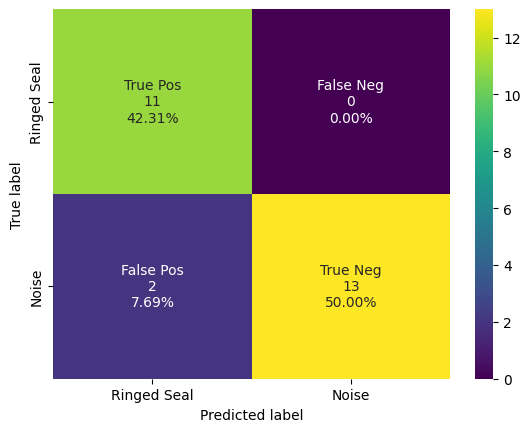

In [32]:
threshold = 0.2

classifications_file = r'E:\final-baseline-detector\pearce-point\fine-tuning-pp\metrics\classifications.csv'

classifications = pd.read_csv(classifications_file)

classifications_by_threshold = classifications[classifications['threshold']==threshold]

predictions = classifications_by_threshold['predicted']

labels = classifications_by_threshold['label']

cm = confusion_matrix_sklearn(predictions, labels)

labels = ['True Pos', 'False Neg', 'False Pos', 'True Neg']
categories = ['Ringed Seal', 'Noise']

confusion_matrix_plot(cm, output_dir, group_names=labels, categories=categories, cmap='viridis')

## All Pearce Point Data

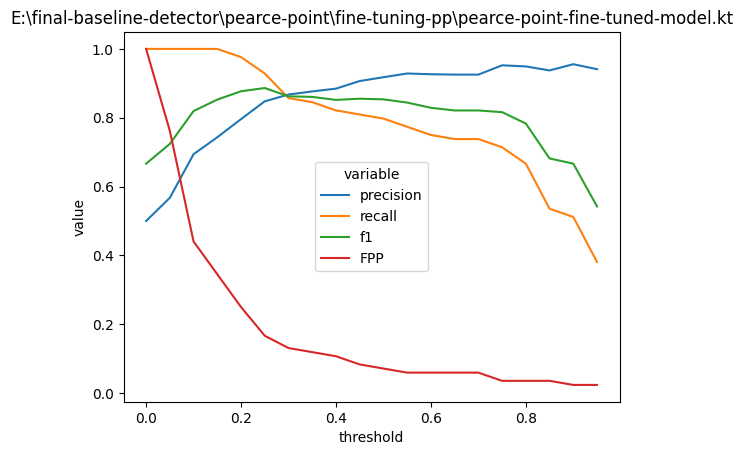

In [34]:
thresholds = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
#thresholds = [0.4]
step_size = 1.0
batch_size = 16
buffer = 0.5

# Get pathway to metrics folder
output_dir = r'E:\final-baseline-detector\pearce-point\fine-tuning-pp\metrics'
main_folder = r'E:\final-baseline-detector'
db_name = r'E:\final-baseline-detector\pearce-point\pp-all.h5'
model_name = r'E:\final-baseline-detector\pearce-point\fine-tuning-pp\pearce-point-fine-tuned-model.kt'
temp_folder = r'E:\final-baseline-detector\pearce-point\fine-tuning-pp\temp'

# Open the database in read only file
db = dbi.open_file(db_name, 'r')

# Open the table in the database at the root level
table = dbi.open_table(db, '/train')

classification_csv = "classifications-all-data.csv"
metric_csv = "metrics-all-data.csv"
stats_csv = "stats-all-data.csv"

# Load the trained model
model = ResNetInterface.load(model_name, load_audio_repr=False, new_model_folder=temp_folder)

# Initialize Joint Batch Generator
gens = []

# Calculate the batch_size fixing the original batch size so there are no remainders
batch_size = int(batch_size / sum(1 for _ in db.walk_nodes(table, "Table")))

# for the testing dataset table in the database (or whatever table is passed in)
for group in db.walk_nodes(table, "Table"):
    # Create a batch generator for this table
    generator = BatchGenerator(batch_size=batch_size, data_table=group,
                               output_transform_func=ResNetInterface.transform_batch, shuffle=False,
                               refresh_on_epoch_end=False, x_field='data', return_batch_ids=True)

    # Append the generator to the gens array
    gens.append(generator)

# Create a joint batch generator if multiple tables are passed through
gen = JointBatchGen(gens, n_batches='min', shuffle_batch=False, reset_generators=False, return_batch_ids=True)

# Initialize the scores and labels
scores = []
labels = []

# For each batch in the joint batch generator
for batch_id in range(gen.n_batches):
    # Get the ids, spectrograms, and labels for the data in the batch
    hdf5_ids, batch_X, batch_Y = next(gen)

    # Get the labels for the batch data, using the "argmax" func which returns the col header, so 0 is a noise segment, 1 is a rs segment
    batch_labels = np.argmax(batch_Y, axis=1)

    # Returns the scores for the batch for the "positive" class - this is used in the compute detections function later on
    batch_scores = model.model.predict_on_batch(batch_X)[:, 1]

    # Add these scores for this batch to the overall list
    scores.extend(batch_scores)
    labels.extend(batch_labels)

# Create a numpy array for the labels and scores for all batches
labels = np.array(labels)
scores = np.array(scores)

df_groups = pd.DataFrame()
df_stats = pd.DataFrame(columns = ['threshold', 'precision', 'recall', 'f1', 'FPP'])

for threshold in thresholds:

    df_group = pd.DataFrame()

    # Compute the predictions, TP, TN, FP, and FN
    # Predicted is an array are greater than a certain threshold, 1 for the score was, 0 for it was not
    predicted, TP, TN, FP, FN = compute_detections(labels, scores, threshold)

    # Create the "classifications" csv file
    for group in db.walk_nodes(table, "Table"):
        df = pd.DataFrame({'id': group[:]['id'], 'filename': group[:]['filename']})
        df_group = pd.concat([df_group, df], ignore_index=True)
    df_group['threshold'] = threshold
    df_group['label'] = labels[:]
    df_group['predicted'] = predicted[:]
    df_group['score'] = scores[:]

    # Calculate performance metrics
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)
    FPP = FP / (TN + FP)

    stats = [threshold, precision, recall, f1, FPP]

    df_groups = pd.concat([df_groups, df_group])
    df_stats.loc[len(df_stats)] = stats

df_groups.to_csv(os.path.join(os.getcwd(), output_dir, classification_csv), mode='w', index=False)
df_stats.to_csv(os.path.join(os.getcwd(), output_dir, stats_csv), mode='w', index=False)

sns.lineplot(x='threshold', y='value', hue='variable', data=pd.melt(df_stats, ['threshold']))
plt.title(model_name)

db.close()

Confusion Matrix


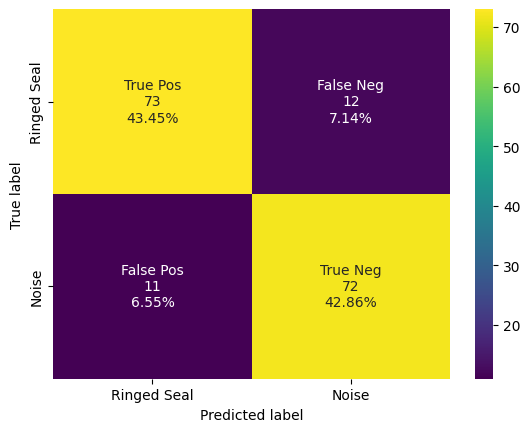

In [36]:
threshold = 0.3

classifications_file = r'E:\final-baseline-detector\pearce-point\fine-tuning-pp\metrics\classifications-all-data.csv'

classifications = pd.read_csv(classifications_file)

classifications_by_threshold = classifications[classifications['threshold']==threshold]

predictions = classifications_by_threshold['predicted']

labels = classifications_by_threshold['label']

cm = confusion_matrix_sklearn(predictions, labels)

labels = ['True Pos', 'False Neg', 'False Pos', 'True Neg']
categories = ['Ringed Seal', 'Noise']

confusion_matrix_plot(cm, output_dir, group_names=labels, categories=categories, cmap='viridis')

# Further Fine Tuning

Can go even further back in the layers 

In [25]:
main_folder = r'E:\final-baseline-detector\pearce-point\fine-tuning-pp\test-freeze-blocks'
pretrained_model = r'E:\final-baseline-detector\final-baseline-model.kt'
new_model = r'E:\final-baseline-detector\pearce-point\fine-tuning-pp\test-freeze-blocks\further-fine-tune-4and5.kt'
spectro_file = r'E:\final-baseline-detector\spec_config_100-1200Hz-0.032-hamm.json'
db_name = r'E:\final-baseline-detector\pearce-point\pp-split.h5'

# Set the random seed for numpy and tensorflow
np.random.seed(1000)
tf.random.set_seed(2000)

# Set the batch size and number of epochs for training
batch_size = 16
n_epochs = 200

# Set the log folder and checkpoint folder
log_folder = main_folder + '\\' + 'logs'
checkpoint_folder = main_folder + '\\' + 'checkpoints'

# Open the database file in read mode
db = dbi.open_file(db_name, 'r')

# Open the training and validation tables respectively
train_data = dbi.open_table(db, "/train/data")
val_data = dbi.open_table(db, "/test/data")

# Create batches of training data of size batch size, using the specified data table
# This returns indices of the data in each batch along with their labels
train_generator = BatchGenerator(batch_size=batch_size, data_table=train_data,
                                    output_transform_func=ResNetInterface.transform_batch,
                                    shuffle=True, refresh_on_epoch_end=True)

# Create batches of validation data of size batch size, using the specified data table
# This returns indices of the data in each batch along with their labels
val_generator = BatchGenerator(batch_size=batch_size, data_table=val_data,
                                   output_transform_func=ResNetInterface.transform_batch,
                                   shuffle=False, refresh_on_epoch_end=False)

# Build the ResNet model file based off of the recipe file - this creates a "ResNetInterface" object
resnet = ResNetInterface.load(pretrained_model, replace_top=True)

# Unfreeze block 
# Calls self.layers[1].layers[block_id].trainable and sets it to True (will be false when loading in a pretrained model) 
# My model is 0-5
resnet.model.unfreeze_block(5)
resnet.model.unfreeze_block(4)

# Set the training and validation generators to the batch generators created above
resnet.train_generator = train_generator
resnet.val_generator = val_generator

# Set the model log and checkpoint directory
resnet.log_dir = log_folder
resnet.checkpoint_dir = checkpoint_folder

# digging into their scripts for fine tuning
# resnet.py, "clone with new top"

# Train the model, looping through all of the training and validation data
# See code map for more information
resnet.train_loop(n_epochs=n_epochs, verbose=False, log_csv=True, csv_name='log.csv', validate=True)
#resnet.train_loop(n_epochs=n_epochs, verbose=False, log_csv=True, csv_name='log.csv', validate=False)

# Close the database
db.close()

# Save the model file, and keep track of the spectrogram parameters used to generate that model
resnet.save(new_model, audio_repr_file=spectro_file)

print('Done')

Done


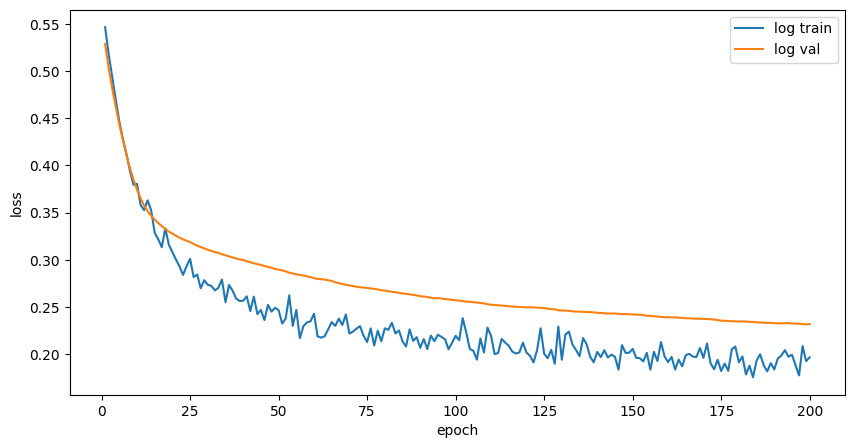

In [26]:
# Get path to folder containing logs 
log_folder = r'E:\final-baseline-detector\pearce-point\fine-tuning-pp\test-freeze-blocks\logs'

files = glob.glob(log_folder  + "/*.csv")

fig, axes = plt.subplots(1, 1, figsize=(10, 5), sharey=True)
#axes.set_ylim(0.1, 0.20)

for file in files:

    # Read the log file 
    log_file = pd.read_csv(file)

    labell = file.split('\\')[-1].split(".")[0]
    
    # Get the training and validation losses 
    tr_results = log_file[log_file['dataset']=='train']
    va_results = log_file[log_file['dataset']=='val']
    
    # Plot the loss curves 
    sns.lineplot(data=tr_results, x='epoch', y='loss', label= str(labell) + ' train', legend='auto')
    sns.lineplot(data=va_results, x='epoch', y='loss', label=str(labell) + ' val', legend='auto') 

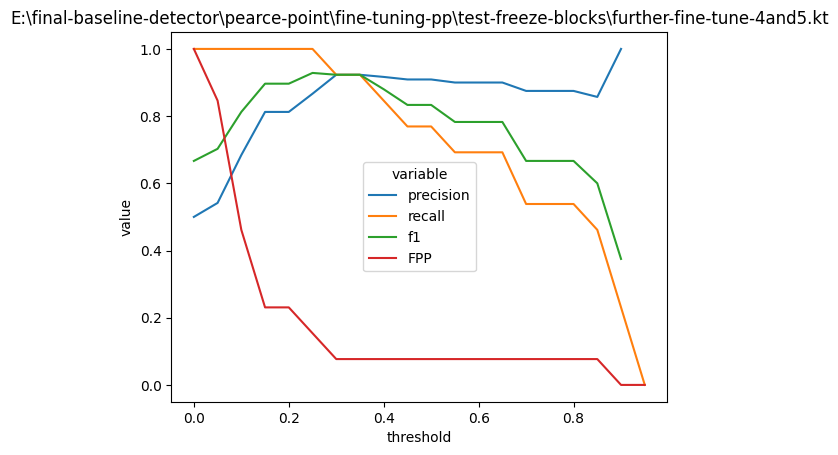

In [27]:
thresholds = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
#thresholds = [0.4]
step_size = 1.0
batch_size = 16
buffer = 0.5

# Get pathway to metrics folder
output_dir = r'E:\final-baseline-detector\pearce-point\fine-tuning-pp\test-freeze-blocks'
main_folder = r'E:\final-baseline-detector\pearce-point\fine-tuning-pp\test-freeze-blocks'
db_name = r'E:\final-baseline-detector\pearce-point\pp-split.h5'
model_name = r'E:\final-baseline-detector\pearce-point\fine-tuning-pp\test-freeze-blocks\further-fine-tune-4and5.kt'
temp_folder = r'E:\final-baseline-detector\pearce-point\fine-tuning-pp\test-freeze-blocks\temp'

# Open the database in read only file
db = dbi.open_file(db_name, 'r')

# Open the table in the database at the root level
table = dbi.open_table(db, '/test')

classification_csv = "classifications.csv"
metric_csv = "metrics.csv"
stats_csv = "stats.csv"

# Load the trained model
model = ResNetInterface.load(model_name, load_audio_repr=False, new_model_folder=temp_folder)

# Initialize Joint Batch Generator
gens = []

# Calculate the batch_size fixing the original batch size so there are no remainders
batch_size = int(batch_size / sum(1 for _ in db.walk_nodes(table, "Table")))

# for the testing dataset table in the database (or whatever table is passed in)
for group in db.walk_nodes(table, "Table"):
    # Create a batch generator for this table
    generator = BatchGenerator(batch_size=batch_size, data_table=group,
                               output_transform_func=ResNetInterface.transform_batch, shuffle=False,
                               refresh_on_epoch_end=False, x_field='data', return_batch_ids=True)

    # Append the generator to the gens array
    gens.append(generator)

# Create a joint batch generator if multiple tables are passed through
gen = JointBatchGen(gens, n_batches='min', shuffle_batch=False, reset_generators=False, return_batch_ids=True)

# Initialize the scores and labels
scores = []
labels = []

# For each batch in the joint batch generator
for batch_id in range(gen.n_batches):
    # Get the ids, spectrograms, and labels for the data in the batch
    hdf5_ids, batch_X, batch_Y = next(gen)

    # Get the labels for the batch data, using the "argmax" func which returns the col header, so 0 is a noise segment, 1 is a rs segment
    batch_labels = np.argmax(batch_Y, axis=1)

    # Returns the scores for the batch for the "positive" class - this is used in the compute detections function later on
    batch_scores = model.model.predict_on_batch(batch_X)[:, 1]

    # Add these scores for this batch to the overall list
    scores.extend(batch_scores)
    labels.extend(batch_labels)

# Create a numpy array for the labels and scores for all batches
labels = np.array(labels)
scores = np.array(scores)

df_groups = pd.DataFrame()
df_stats = pd.DataFrame(columns = ['threshold', 'precision', 'recall', 'f1', 'FPP'])

for threshold in thresholds:

    df_group = pd.DataFrame()

    # Compute the predictions, TP, TN, FP, and FN
    # Predicted is an array are greater than a certain threshold, 1 for the score was, 0 for it was not
    predicted, TP, TN, FP, FN = compute_detections(labels, scores, threshold)

    # Create the "classifications" csv file
    for group in db.walk_nodes(table, "Table"):
        df = pd.DataFrame({'id': group[:]['id'], 'filename': group[:]['filename']})
        df_group = pd.concat([df_group, df], ignore_index=True)
    df_group['threshold'] = threshold
    df_group['label'] = labels[:]
    df_group['predicted'] = predicted[:]
    df_group['score'] = scores[:]

    # Calculate performance metrics
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)
    FPP = FP / (TN + FP)

    stats = [threshold, precision, recall, f1, FPP]

    df_groups = pd.concat([df_groups, df_group])
    df_stats.loc[len(df_stats)] = stats

df_groups.to_csv(os.path.join(os.getcwd(), output_dir, classification_csv), mode='w', index=False)
df_stats.to_csv(os.path.join(os.getcwd(), output_dir, stats_csv), mode='w', index=False)

sns.lineplot(x='threshold', y='value', hue='variable', data=pd.melt(df_stats, ['threshold']))
plt.title(model_name)

db.close()

Confusion Matrix


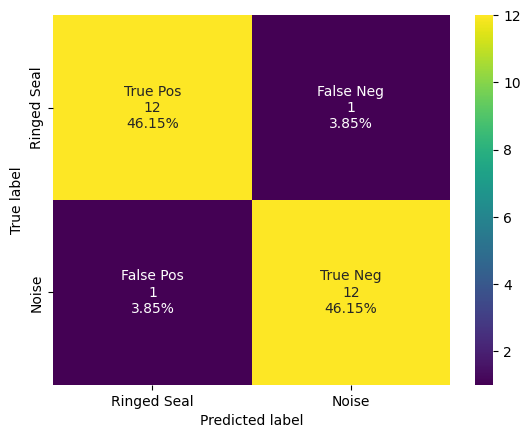

In [28]:
threshold = 0.3

classifications_file = r'E:\final-baseline-detector\pearce-point\fine-tuning-pp\test-freeze-blocks\classifications.csv'

classifications = pd.read_csv(classifications_file)

classifications_by_threshold = classifications[classifications['threshold']==threshold]

predictions = classifications_by_threshold['predicted']

labels = classifications_by_threshold['label']

cm = confusion_matrix_sklearn(predictions, labels)

labels = ['True Pos', 'False Neg', 'False Pos', 'True Neg']
categories = ['Ringed Seal', 'Noise']

confusion_matrix_plot(cm, output_dir, group_names=labels, categories=categories, cmap='viridis')

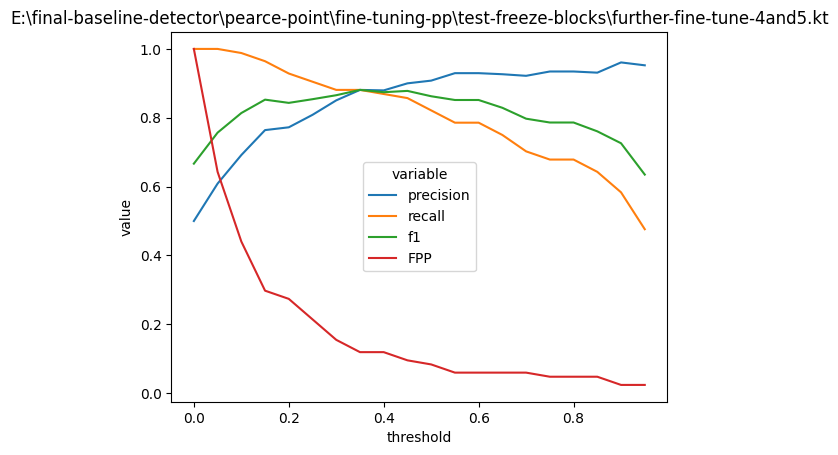

In [29]:
thresholds = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
#thresholds = [0.4]
step_size = 1.0
batch_size = 16
buffer = 0.5

# Get pathway to metrics folder
output_dir = r'E:\final-baseline-detector\pearce-point\fine-tuning-pp\test-freeze-blocks\metrics-all-data'
main_folder = r'E:\final-baseline-detector\pearce-point\fine-tuning-pp\test-freeze-blocks'
db_name = r'E:\final-baseline-detector\pearce-point\pp-all.h5'
model_name = r'E:\final-baseline-detector\pearce-point\fine-tuning-pp\test-freeze-blocks\further-fine-tune-4and5.kt'
temp_folder = r'E:\final-baseline-detector\pearce-point\fine-tuning-pp\test-freeze-blocks\temp'

# Open the database in read only file
db = dbi.open_file(db_name, 'r')

# Open the table in the database at the root level
table = dbi.open_table(db, '/train')

classification_csv = "classifications-all-data.csv"
metric_csv = "metrics-all-data.csv"
stats_csv = "stats-all-data.csv"

# Load the trained model
model = ResNetInterface.load(model_name, load_audio_repr=False, new_model_folder=temp_folder)

# Initialize Joint Batch Generator
gens = []

# Calculate the batch_size fixing the original batch size so there are no remainders
batch_size = int(batch_size / sum(1 for _ in db.walk_nodes(table, "Table")))

# for the testing dataset table in the database (or whatever table is passed in)
for group in db.walk_nodes(table, "Table"):
    # Create a batch generator for this table
    generator = BatchGenerator(batch_size=batch_size, data_table=group,
                               output_transform_func=ResNetInterface.transform_batch, shuffle=False,
                               refresh_on_epoch_end=False, x_field='data', return_batch_ids=True)

    # Append the generator to the gens array
    gens.append(generator)

# Create a joint batch generator if multiple tables are passed through
gen = JointBatchGen(gens, n_batches='min', shuffle_batch=False, reset_generators=False, return_batch_ids=True)

# Initialize the scores and labels
scores = []
labels = []

# For each batch in the joint batch generator
for batch_id in range(gen.n_batches):
    # Get the ids, spectrograms, and labels for the data in the batch
    hdf5_ids, batch_X, batch_Y = next(gen)

    # Get the labels for the batch data, using the "argmax" func which returns the col header, so 0 is a noise segment, 1 is a rs segment
    batch_labels = np.argmax(batch_Y, axis=1)

    # Returns the scores for the batch for the "positive" class - this is used in the compute detections function later on
    batch_scores = model.model.predict_on_batch(batch_X)[:, 1]

    # Add these scores for this batch to the overall list
    scores.extend(batch_scores)
    labels.extend(batch_labels)

# Create a numpy array for the labels and scores for all batches
labels = np.array(labels)
scores = np.array(scores)

df_groups = pd.DataFrame()
df_stats = pd.DataFrame(columns = ['threshold', 'precision', 'recall', 'f1', 'FPP'])

for threshold in thresholds:

    df_group = pd.DataFrame()

    # Compute the predictions, TP, TN, FP, and FN
    # Predicted is an array are greater than a certain threshold, 1 for the score was, 0 for it was not
    predicted, TP, TN, FP, FN = compute_detections(labels, scores, threshold)

    # Create the "classifications" csv file
    for group in db.walk_nodes(table, "Table"):
        df = pd.DataFrame({'id': group[:]['id'], 'filename': group[:]['filename']})
        df_group = pd.concat([df_group, df], ignore_index=True)
    df_group['threshold'] = threshold
    df_group['label'] = labels[:]
    df_group['predicted'] = predicted[:]
    df_group['score'] = scores[:]

    # Calculate performance metrics
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)
    FPP = FP / (TN + FP)

    stats = [threshold, precision, recall, f1, FPP]

    df_groups = pd.concat([df_groups, df_group])
    df_stats.loc[len(df_stats)] = stats

df_groups.to_csv(os.path.join(os.getcwd(), output_dir, classification_csv), mode='w', index=False)
df_stats.to_csv(os.path.join(os.getcwd(), output_dir, stats_csv), mode='w', index=False)

sns.lineplot(x='threshold', y='value', hue='variable', data=pd.melt(df_stats, ['threshold']))
plt.title(model_name)

db.close()

Confusion Matrix


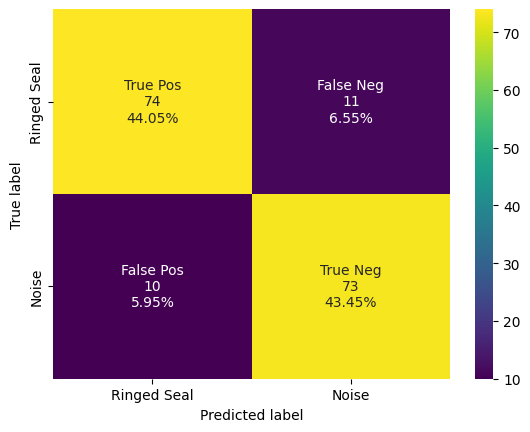

In [30]:
threshold = 0.4

classifications_file = r'E:\final-baseline-detector\pearce-point\fine-tuning-pp\test-freeze-blocks\metrics-all-data\classifications-all-data.csv'

classifications = pd.read_csv(classifications_file)

classifications_by_threshold = classifications[classifications['threshold']==threshold]

predictions = classifications_by_threshold['predicted']

labels = classifications_by_threshold['label']

cm = confusion_matrix_sklearn(predictions, labels)

labels = ['True Pos', 'False Neg', 'False Pos', 'True Neg']
categories = ['Ringed Seal', 'Noise']

confusion_matrix_plot(cm, output_dir, group_names=labels, categories=categories, cmap='viridis')

In [32]:
main_folder = r'E:\final-baseline-detector\pearce-point\fine-tuning-pp\test-freeze-blocks'
temp_folder_pp = main_folder + '\\' + 'ringedS_tmp_folder_ft'
detections_csv = main_folder + '\\' + 'detections_raw_fine_tuned_block5.csv'
model_name = r'E:\final-baseline-detector\pearce-point\fine-tuning-pp\test-freeze-blocks\further-fine-tune-4and5.kt'
audio_folder = r'E:\final-baseline-detector\pearce-point\audio'

# Look at detections at this threshold
threshold = 0.4

# Step 0.5s each time (overlap of 50% for 1 sec duration)
step_size = 0.5

# Number of samples in batch
batch_size = 16

model = ResNetInterface.load(model_file=model_name, new_model_folder=temp_folder_pp)

audio_repr = load_audio_representation(path=spectro_file)

spec_config = audio_repr['spectrogram']

audio_loader = AudioFrameLoader(path=audio_folder, duration=spec_config['duration'],
                                    step=step_size, stop=False, representation=spec_config['type'],
                                    representation_params=spec_config, pad=False)
detections = pd.DataFrame()

batch_generator = batch_load_audio_file_data(loader=audio_loader, batch_size=batch_size)

for batch_data in batch_generator:
    # Run the model on the spectrogram data from the current batch
    batch_predictions = model.run_on_batch(batch_data['data'], return_raw_output=True)

    # Lets store our data in a dictionary
    raw_output = {'filename': batch_data['filename'], 'start': batch_data['start'], 'end': batch_data['end'],
                  'score': batch_predictions}

    batch_detections = filter_by_threshold(raw_output, threshold=threshold)

    detections = pd.concat([detections, batch_detections], ignore_index=True)

#detections.to_csv(detections_csv, index=False)

100%|████████████████████████████████████████████████████████████████████████████████| 598/598 [00:36<00:00, 16.27it/s]


In [33]:
# Filter the detections for only the positive results 
detections_filtered = filter_by_label(detections, labels=1).reset_index(drop=True)
print(detections_filtered)
detections_grp = merge_overlapping_detections(detections_filtered)
print(detections_grp)
detections_grp.to_csv(r'E:\final-baseline-detector\pearce-point\fine-tuning-pp\test-freeze-blocks\detections_raw_fine_tuned_block4and5.csv', index=False)

                         filename  start    end  label     score
0     1208234033.020419202219.wav   57.5   58.5      1  0.799419
1     1208234033.020419202219.wav   58.0   59.0      1  0.945192
2     1208234033.020419202219.wav   58.5   59.5      1  0.421339
3     1208234033.020419202219.wav   69.5   70.5      1  0.961691
4     1208234033.020419202219.wav  107.5  108.5      1  0.904194
...                           ...    ...    ...    ...       ...
1402  1208234033.021207082219.wav  259.0  260.0      1  0.861996
1403  1208234033.021207082219.wav  259.5  260.5      1  0.560602
1404  1208234033.021207082219.wav  276.0  277.0      1  0.597882
1405  1208234033.021207082219.wav  291.5  292.5      1  0.604223
1406  1208234033.021207082219.wav  292.0  293.0      1  0.616035

[1407 rows x 5 columns]
                        filename  start    end  label     score
0    1208234033.020419202219.wav   57.5   59.5      1  0.646822
1    1208234033.020419202219.wav   69.5   70.5      1  0.961691
2  